## BERT

Fine-tune the BERT (bert-base-uncased) for text classification and report accuracy, macro f1-score, and micro f1-score. If you are using PyTorch, hugging face transformers is highly recommended for this task. While tokenizing, set the maximum length to 64 and fine-tune for 3 epochs.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# custom visualisation styling
custom = {"axes.edgecolor": "red", "grid.linestyle": "dashed", "grid.color": "black"}
sns.set_style("darkgrid", rc=custom)

In [2]:
# load dataset
data = pd.read_csv("nyt.csv")
print(data.shape)

(11519, 2)


In [3]:
data.head()

,text,label
0,(reuters) - carlos tevez sealed his move to ju...,sports
1,if professional pride and strong defiance can ...,sports
2,"palermo, sicily — roberta vinci beat top-seede...",sports
3,spain's big two soccer teams face a pair of it...,sports
4,the argentine soccer club san lorenzo complete...,sports


label
sports      8639
politics    1451
business    1429
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

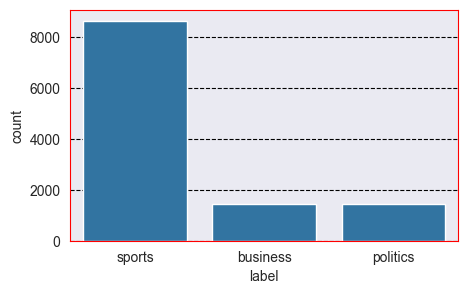

In [4]:
# see class distribution - multiclass problem
df = data.copy()
print(df['label'].value_counts())

plt.figure(figsize=(5,3))
sns.countplot(data=df, x='label')

In [5]:
# classes are imbalanced
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['label']), y=df['label'].values)
class_weight_dict = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2]}
print(class_weight_dict)

{0: 2.6869605784931188, 1: 2.646220997013554, 2: 0.4444573060153567}


In [6]:
# mapping of label to codes
mapped_classes = df.label.astype('category')
hm_class = dict(enumerate(mapped_classes.cat.categories))
print(hm_class)

df['label'] = df.label.astype('category').cat.codes

# 1 hot encoding
one_hot = pd.get_dummies(df['label'])
df['label'] = one_hot.apply(lambda row: row.values, axis=1)

{0: 'business', 1: 'politics', 2: 'sports'}


In [7]:
# Note: in case of Bert, removing the stopwords might actually worsen the metrics
df['text'] = df['text'].str.replace(r'[^\w\s]', ' ', regex=True)
df['text'] = df['text'].str.replace(r'[\{\}\[\]\(\)]', '', regex=True)

In [8]:
# convert to huggingface dataset format
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['text', 'label'],
    num_rows: 11519
})

In [9]:
# train test validation splits
train_test_splits = ds.train_test_split(test_size=0.2)
test_validation_splits = train_test_splits['test'].train_test_split(test_size=0.5)

# collate all in a dict
tweet_dataset = DatasetDict({
    'train': train_test_splits['train'],
    'test': test_validation_splits['test'],
    'valid': test_validation_splits['train']
})

tweet_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9215
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1152
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 1152
    })
})

### Tokenizer

In [10]:
# loading a pre-trained BERT tokenizer that corresponds to the "bert-base-uncased" model.
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [11]:
# preprocess
def preprocess(ds):
    return tokenizer(
        ds['text'], 
        padding='max_length', 
        truncation=True, 
        max_length=64
    )

# When batched=True, the preprocess function will receive a batch of samples as input instead of a single sample. Faster.
tokenized_dataset = tweet_dataset.map(preprocess, batched=True, batch_size=32, remove_columns=["text"])

train_dataset = tokenized_dataset['train'].with_format('tensorflow')
eval_dataset = tokenized_dataset['valid'].with_format('tensorflow')
test_dataset = tokenized_dataset['test'].with_format('tensorflow')

Map:   0%|          | 0/9215 [00:00<?, ? examples/s]

Map:   0%|          | 0/1152 [00:00<?, ? examples/s]

Map:   0%|          | 0/1152 [00:00<?, ? examples/s]

In [12]:
# batching
batch_size=16

def preprocess_batch_dataset(dataset):
    # When you pass in a tensor (or a tuple of tensors), from_tensor_slices treats each entry (or "slice") in the tensor as a separate element in the dataset.
    dataset = tf.data.Dataset.from_tensor_slices((
        {x: dataset[x] for x in tokenizer.model_input_names}, 
        dataset["label"]
        # tf.keras.utils.to_categorical(dataset["label"], num_classes=3)
    ))

    # shuffle and create batches
    # buffer_size=1000 specifies the number of elements from which to sample when shuffling
    dataset = dataset.shuffle(buffer_size=len(dataset)).batch(batch_size)
    return dataset

# batch dataset
train_dataset_bt, eval_dataset_bt, test_dataset_bt = [preprocess_batch_dataset(ds) for ds in [train_dataset, eval_dataset, test_dataset]]

In [13]:
# check if batch created
first_batch = next(iter(train_dataset_bt.take(1)))
print(first_batch[0]['input_ids'].shape)

(16, 64)


In [14]:
# save ground truth y in test
labels_list = []
for batch in test_dataset_bt:
    labels_list.extend(batch[1].numpy())

test_truth = np.argmax(labels_list, axis=1)

2024-10-17 03:05:34.587556: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
from collections import Counter
Counter(test_truth)

Counter({2: 864, 0: 146, 1: 142})

### Define Model

In [16]:
# load a pre-trained tf model
# hf trainer class - Trainer is primarily designed for PyTorch models, not TensorFlow models.
model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    problem_type="multi_label_classification",
    num_labels=3,
    id2label=hm_class,
    label2id={v: k for k, v in hm_class.items()}
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training

In [17]:
def lr_scheduler(epoch):
    epoch_tensor = tf.convert_to_tensor(epoch, dtype=tf.float32)
    if epoch > 1:
        return 0.00005 * tf.math.exp(-epoch_tensor)
    else: 
        return 0.00005

In [18]:
# metrics
def f1_micro(y_true, y_pred):
    y_true_indices = tf.argmax(y_true, axis=-1)
    y_pred_indices = tf.argmax(y_pred, axis=-1)
    return f1_score(y_true_indices.numpy(), y_pred_indices.numpy(), average='micro')

def f1_macro(y_true, y_pred):
    y_true_indices = tf.argmax(y_true, axis=-1)
    y_pred_indices = tf.argmax(y_pred, axis=-1)
    return f1_score(y_true_indices.numpy(), y_pred_indices.numpy(), average='macro')

# Wrapping them in a TensorFlow function for compatibility
@tf.function
def f1_micro_metric(y_true, y_pred):
    return tf.py_function(f1_micro, [y_true, y_pred], tf.double)

@tf.function
def f1_macro_metric(y_true, y_pred):
    return tf.py_function(f1_macro, [y_true, y_pred], tf.double)

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.metrics.CategoricalAccuracy(), f1_micro_metric, f1_macro_metric]
)

history = model.fit(
    train_dataset_bt,
    epochs=3,
    validation_data=eval_dataset_bt,
    # class_weight=class_weight_dict,
    callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)],
    verbose=True
)

Epoch 1/3
576/576 [==============================] - 824s 1s/step - loss: 0.1495 - categorical_accuracy: 0.9485 - f1_micro_metric: 0.9485 - f1_macro_metric: 0.8554 - val_loss: 0.0805 - val_categorical_accuracy: 0.9714 - val_f1_micro_metric: 0.9714 - val_f1_macro_metric: 0.9091 - lr: 5.0000e-05
Epoch 2/3
576/576 [==============================] - 807s 1s/step - loss: 0.0514 - categorical_accuracy: 0.9844 - f1_micro_metric: 0.9844 - f1_macro_metric: 0.9544 - val_loss: 0.0761 - val_categorical_accuracy: 0.9748 - val_f1_micro_metric: 0.9748 - val_f1_macro_metric: 0.9418 - lr: 5.0000e-05
Epoch 3/3
576/576 [==============================] - 806s 1s/step - loss: 0.0193 - categorical_accuracy: 0.9945 - f1_micro_metric: 0.9945 - f1_macro_metric: 0.9853 - val_loss: 0.0757 - val_categorical_accuracy: 0.9757 - val_f1_micro_metric: 0.9757 - val_f1_macro_metric: 0.9452 - lr: 6.7668e-06


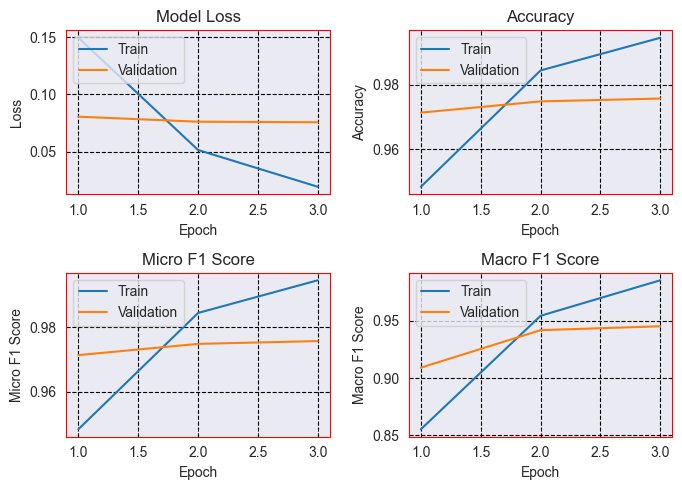

In [20]:
# visualisation
def plot_metric(ax, x, y_train, y_val, title, ylabel, xlabel):
    ax.plot(x, y_train, label='Train')
    ax.plot(x, y_val, label='Validation')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.legend(loc='upper left')

def plot_history(history):
    # 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(7, 5))  # Adjust figsize for better visibility

    # Epochs
    epochs = range(1, len(history.history['loss']) + 1)

    # Loss
    plot_metric(axs[0, 0], epochs, history.history['loss'], history.history['val_loss'], 
                'Model Loss', 'Loss', 'Epoch')
    # Accuracy
    plot_metric(axs[0, 1], epochs, history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                'Accuracy', 'Accuracy', 'Epoch')

    # Micro F1 Score
    plot_metric(axs[1, 0], epochs, history.history['f1_micro_metric'], history.history['val_f1_micro_metric'], 
                'Micro F1 Score', 'Micro F1 Score', 'Epoch')

    # Macro F1 Score
    plot_metric(axs[1, 1], epochs, history.history['f1_macro_metric'], history.history['val_f1_macro_metric'], 
                'Macro F1 Score', 'Macro F1 Score', 'Epoch')

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_history(history)

In [22]:
# inference on test set
test_loss, test_acc, test_f1_micro, test_f1_macro = model.evaluate(test_dataset_bt, verbose=2)

print("Accuracy:", test_acc)
print("Micro F1 Score:", test_f1_micro)
print("Macro F1 Score:", test_f1_macro)

72/72 - 32s - loss: 0.0859 - categorical_accuracy: 0.9757 - f1_micro_metric: 0.9757 - f1_macro_metric: 0.9336 - 32s/epoch - 447ms/step
Accuracy: 0.9756944179534912
Micro F1 Score: 0.9756944179534912
Macro F1 Score: 0.9336167573928833
